# Plot activation map

### Load and preprocess data

In [2]:
import numpy as np
import os

os.environ["CUDA_VISIBLE_DEVICES"]="-1"

# Load data
with np.load(os.path.join('mnist-20k.npz'), allow_pickle=False) as npz_file:
    mnist = dict(npz_file.items())
    
# Convert pixels into floating point numbers
data = mnist['data'].astype(np.float32)

# Rescale pixel values between -0.5 and 0.5
data = (data - 128) / 255

In [3]:
from sklearn.model_selection import train_test_split

# Split into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    # Reshape images (28 by 28)
    data.reshape(-1, 28, 28, 1), # single channel (grayscale)
    mnist['labels'],
    test_size=500, random_state=0
)

# Print shape
print('Train:', X_train.shape, y_train.shape)
print('Valid:', X_valid.shape, y_valid.shape)

Train: (19500, 28, 28, 1) (19500,)
Valid: (500, 28, 28, 1) (500,)


### Define the network

In [4]:
import tensorflow as tf

# Define graph
graph = tf.Graph()

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    
    # Convolution
    conv = tf.layers.conv2d(
        X, # Input data
        filters=16, # 16 filters
        kernel_size=(5, 5), # Kernel size: 5x5
        strides=(2, 2), # Stride: 2
        padding='SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(
            stddev=0.01, seed=0), # Small standard deviation
        name='conv' # Add name
    )
    
    # Get the kernel weights
    with tf.variable_scope('conv', reuse=True):
        conv_kernels = tf.get_variable('kernel')
    
    # Max pooling layer
    pool = tf.layers.max_pooling2d(
        conv, # Convolution output
        pool_size=(2, 2), # Pool size: 2
        strides=(2, 2), # Stride: 2
        padding='SAME' # "same" padding
    )
    
    # Convolution
    conv2 = tf.layers.conv2d(
        pool, # Max pooling output
        filters=16, # 16 filters
        kernel_size=(3, 3), # Kernel size: 3x3
        strides=(1, 1), # Stride: 1
        padding='SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(
            stddev=0.01, seed=0), # Small standard deviation
        name='conv2' # Add name
    )
    
    # Max pooling layer (2x2, stride: 2)
    pool2 = tf.layers.max_pooling2d(
        conv2, pool_size=(2, 2), strides=(2, 2), padding='SAME')
    
    # Flatten output
    flat_output = tf.contrib.layers.flatten(pool2)
    
    # Output layer
    logits = tf.layers.dense(
        flat_output, 10, # Output units: 10
        activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))
    
    # Adam optimizer
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.AdamOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)
    
    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

C:\Users\lyeso\anaconda3\envs\exts-ml\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Train network

In [5]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)
    
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

In [6]:
with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Set seed
    np.random.seed(0)
    
    # Train several epochs
    for epoch in range(10):
        # Accuracy values (train) after each batch
        batch_acc = []
        
        for X_batch, y_batch in get_batches(X_train, y_train, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.001 # Learning rate
            })
            
            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid,
            y: y_valid
        })
        
        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))
    
    # Get 1st conv. layer kernels
    kernels = conv_kernels.eval()
    
    # Pick a sample image and get 1st conv. activations
    activation_maps = conv.eval(feed_dict={
        X: [X_valid[101]] # Pick one image from the validation set
    })

Epoch 1 - valid: 0.934 train: 0.756 (mean)
Epoch 2 - valid: 0.966 train: 0.938 (mean)
Epoch 3 - valid: 0.960 train: 0.950 (mean)
Epoch 4 - valid: 0.968 train: 0.961 (mean)
Epoch 5 - valid: 0.982 train: 0.967 (mean)
Epoch 6 - valid: 0.974 train: 0.971 (mean)
Epoch 7 - valid: 0.982 train: 0.974 (mean)
Epoch 8 - valid: 0.980 train: 0.975 (mean)
Epoch 9 - valid: 0.980 train: 0.978 (mean)
Epoch 10 - valid: 0.978 train: 0.979 (mean)


### Plot kernels

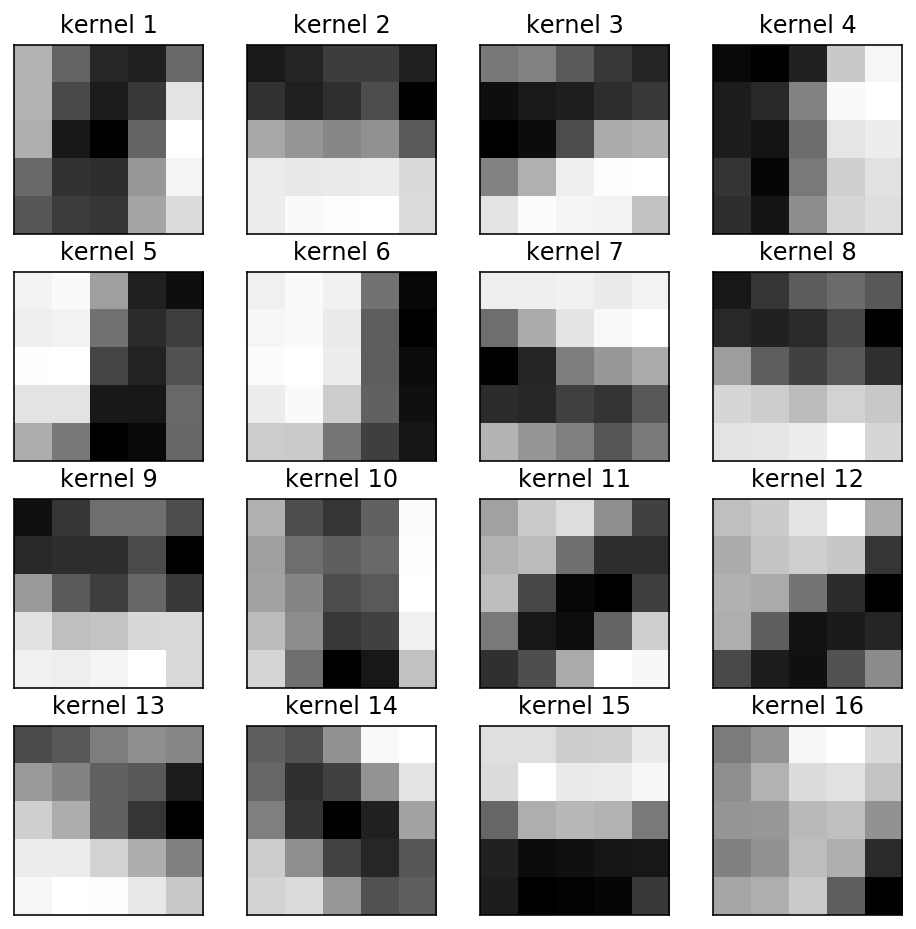

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For retina screens
import matplotlib.pyplot as plt

# Create figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

# Plot the 16 kernels from the first convolutional layer
for i, axis in enumerate(axes.flatten()):
    # Get i-th kernel
    kernel = kernels[:, :, :, i]
    
    # Kernels are 5x5x1 (height, width, channels)
    # Remove last dimension
    kernel = kernel[:, :, 0] # (5, 5) kernel
    
    # Plot kernel with imshow()
    axis.set_title('kernel {}'.format(i+1))
    axis.imshow(kernel, cmap=plt.cm.gray_r)
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis
    
plt.show()

### Plot activation maps

In [8]:
# Print shape of the variable
print('Activation maps:', activation_maps.shape)

Activation maps: (1, 14, 14, 16)


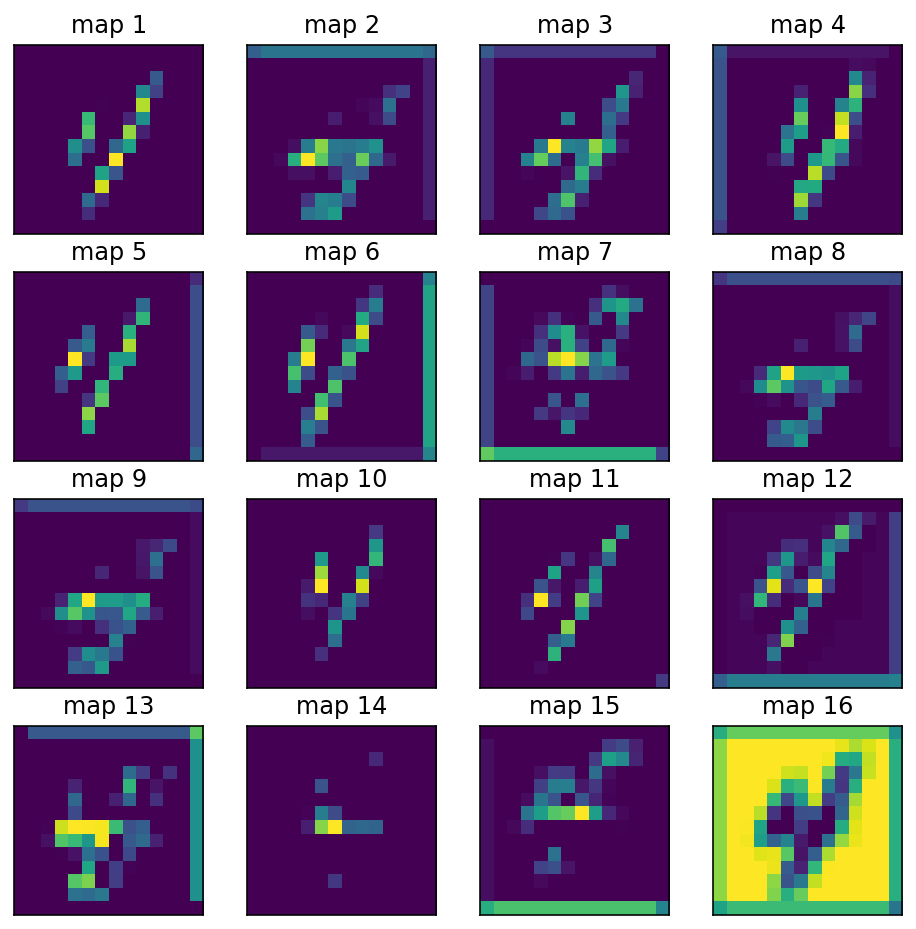

In [9]:
# Create figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

# Plot the activation maps of the 1st conv. layer for the sample image
for i, axis in enumerate(axes.flatten()):
    # Get activation map of the i-th filter
    kernel = activation_maps[0, :, :, i]
    
    # Plot it with imshow()
    axis.set_title('map {}'.format(i+1))
    axis.imshow(kernel)
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis
    
plt.show()